# 10章 アンケート分析を行うための言語処理１０本ノック

ここでは、まちづくりのアンケートを使って分析していきます。  
主に言語処理を取り扱っていきます。
言語処理特有の処理や、データの持たせ方を学びましょう。

### ノック91：データを読み込んで把握しよう

In [16]:
import pandas as pd
survey = pd.read_csv("survey.csv")

In [17]:
print(len(survey))
survey.head()

86


,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている(AA駅),1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [18]:
survey.isna().sum()

datetime        0
comment         2
satisfaction    0
dtype: int64

In [19]:
survey = survey.dropna()
survey.isna().sum()

datetime        0
comment         0
satisfaction    0
dtype: int64

### ノック92：不要な文字を除外してみよう

In [20]:
survey["comment"] = survey["comment"].str.replace("AA", "")
survey["comment"].head()

0     駅前に若者が集まっている(駅)
1    スポーツできる場所があるのが良い
2           子育て支援が嬉しい
3     保育園に入れる（待機児童なし）
4           駅前商店街が寂しい
Name: comment, dtype: object

In [21]:
survey["comment"] = survey["comment"].str.replace("\(.+?\)", "", regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる（待機児童なし）,4
4,2019/1/6,駅前商店街が寂しい,2


In [22]:
survey["comment"] = survey["comment"].str.replace("\（.+?\）", "", regex=True)
survey.head()

,datetime,comment,satisfaction
0,2019/3/11,駅前に若者が集まっている,1
1,2019/2/25,スポーツできる場所があるのが良い,5
2,2019/2/18,子育て支援が嬉しい,5
3,2019/4/9,保育園に入れる,4
4,2019/1/6,駅前商店街が寂しい,2


### ノック93：文字数をカウントしてヒストグラムを表示してみよう

In [23]:
survey["length"] = survey["comment"].str.len()
survey.head()

,datetime,comment,satisfaction,length
0,2019/3/11,駅前に若者が集まっている,1,12
1,2019/2/25,スポーツできる場所があるのが良い,5,16
2,2019/2/18,子育て支援が嬉しい,5,9
3,2019/4/9,保育園に入れる,4,7
4,2019/1/6,駅前商店街が寂しい,2,9


(array([11., 24., 21., 10.,  6.,  6.,  5.,  0.,  0.,  1.]),
 array([ 4. ,  8.6, 13.2, 17.8, 22.4, 27. , 31.6, 36.2, 40.8, 45.4, 50. ]),
 <BarContainer object of 10 artists>)

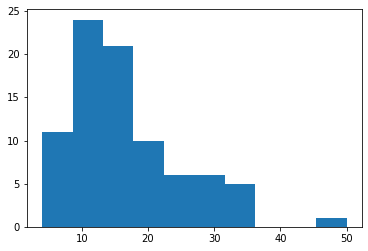

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(survey["length"])

### ノック94：形態素解析で文章を分割してみよう

In [31]:
import MeCab
tagger = MeCab.Tagger()
text = "すもももももももものうち"
words = tagger.parse(text)
words

'すもも\t名詞,一般,*,*,*,*,すもも,スモモ,スモモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nも\t助詞,係助詞,*,*,*,*,も,モ,モ\nもも\t名詞,一般,*,*,*,*,もも,モモ,モモ\nの\t助詞,連体化,*,*,*,*,の,ノ,ノ\nうち\t名詞,非自立,副詞可能,*,*,*,うち,ウチ,ウチ\nEOS\n'

In [27]:
words = tagger.parse(text).splitlines()
words_arr = []
for i in words:
    if i == 'EOS': continue
    word_tmp = i.split()[0]
    words_arr.append(word_tmp)
words_arr

['すもも', 'も', 'もも', 'も', 'もも', 'の', 'うち']

### ノック95：形態素解析で文章から「動詞・名詞」を抽出してみよう

In [35]:
text = 'すもももももももものうち'
words = tagger.parse(text).splitlines()
words_arr = []
parts = ['名詞', '動詞']
for i in words:
    if i == 'EOS' or i == '': continue
    word_tmp = i.split()[0]
    part = i.split()[1].split(',')[0]
    if not (part in parts): continue
    words_arr.append(word_tmp)
words_arr

['すもも', 'もも', 'もも', 'うち']

### ノック96：形態素解析で抽出した頻出する名詞を確認してみよう

In [61]:
all_words = []
for i in survey.comment:
    words = tagger.parse(i).splitlines()
    words_arr = []
    for w in words:
        if w == 'EOS': continue
        category = w.split()[1].split(',')[0]
        if category == '名詞':
            word = w.split()[0]
            all_words.append(word)
all_words[:10]

['駅前', '若者', 'スポーツ', '場所', 'の', '子育て', '支援', '保育園', '駅前', '商店']

In [71]:
all_words_df = pd.DataFrame({'words': all_words, 'count': len(all_words)*[1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False)

,count
words,
駅前,7
場所,6
街,6
の,5
公園,5
...,...
奇麗,1
姿勢,1
子ども,1


### ノック97：関係のない単語を除去しよう

In [83]:
stop_words = ['の']
categories = ['名詞']
all_words = []
for comment in survey.comment:
    words = tagger.parse(comment).splitlines()
    for w in words:
        if w == 'EOS': continue
        category = w.split()[1].split(',')[0]
        candidate = w.split()[0]
        if candidate in stop_words: continue
        if category in categories:
            all_words.append(candidate)
all_words


['駅前',
 '若者',
 'スポーツ',
 '場所',
 '子育て',
 '支援',
 '保育園',
 '駅前',
 '商店',
 '街',
 '生活',
 '便利',
 '場所',
 '場所',
 '商業',
 '施設',
 '病院',
 '充実',
 'サイクリング',
 'コース',
 '祭り',
 '小学校',
 '綺麗',
 '公園',
 '近く',
 '公園',
 'スーパー',
 '大変',
 '子育て',
 'デートスポット',
 '商店',
 '街',
 '夜道',
 'ゴミ',
 '処理',
 '楽',
 '映画',
 '館',
 '街路',
 '樹',
 '公園',
 '追加',
 '観光',
 'スポット',
 '子育て',
 '道',
 '綺麗',
 '都内',
 'アクセス',
 '家賃',
 'リーズナブル',
 'BBB',
 '渋滞',
 '商店',
 '街',
 '屋根',
 '雨',
 '大変',
 '商店',
 '街',
 'たくさん',
 '喫茶店',
 'スポーツ',
 'ジム',
 '利用',
 'スポーツ',
 'ジム',
 '利用',
 '料金',
 'ママ',
 '支援',
 'バス',
 '自転車',
 'ランニング',
 '運動',
 '場所',
 '有名',
 '企業',
 '駅前',
 '駐車',
 '場',
 '変',
 'おじさん',
 '声',
 '事',
 '警察',
 '巡回',
 '強化',
 '消防',
 '団',
 '活発',
 '安心',
 '災害',
 '時',
 '避難',
 '場所',
 '気',
 '最近',
 '川',
 '氾濫',
 '被害',
 '町',
 'よう',
 '氾濫',
 '防止',
 '説明',
 '信号',
 '交差点',
 'ｘｘｘ',
 '事故',
 'そう',
 '信号',
 '商店',
 '街',
 '活性',
 '化',
 '活動',
 '行政',
 '後押し',
 '子ども',
 '安全',
 '場所',
 '駅前',
 '駐輪場',
 '不便',
 '街路',
 '樹',
 '落ち葉',
 '掃除',
 '大変',
 '街路',
 '樹',
 '災害',
 '時',
 '備蓄',
 '状況',
 '歩道',
 '道',
 '安心',
 '地域

In [90]:
all_words_df = pd.DataFrame({'words': all_words, 'count': len(all_words) * [1]})
all_words_df = all_words_df.groupby('words').sum()
all_words_df.sort_values('count', ascending=False)

,count
words,
駅前,7
場所,6
街,6
公園,5
商店,5
...,...
奇麗,1
姿勢,1
子ども,1


### ノック98：顧客満足度と頻出単語の関係をみてみよう

### ノック99：アンケート毎の特徴を表現してみよう

### ノック100：類似アンケートを探してみよう